# Set Covering

In [45]:
from random import random, seed
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt
import math

In [46]:
var_UNIVERSE_SIZE = [100, 1000, 10000, 100000, 100000, 100000]
var_NUM_SETS = [10, 100, 1000, 10000, 10000, 10000]
var_DENSITY = [0.2, 0.2, 0.2, 0.1, 0.2, 0.3]
var_p = [0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
MAX_STEPS = 150
SETS = None
COSTS = None


In [47]:
def generate_sets_and_cots(universe_size, num_sets, density):
    global SETS, COSTS, rng, UNIVERSE_SIZE, NUM_SETS, DENSITY
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density
    
    rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
    SETS = rng.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[rng.integers(num_sets), s] = True
    COSTS = np.power(SETS.sum(axis=1), 1.1)


*Helper function*

In [48]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution)) 
def fitness_improved(solution):
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    return (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))
def starting_point(p):
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < p #0.01 for the first 3 instances, 0.001 for the last 3 instances
    return solution
def plotter(history):
    c_values = [c for v, c in history if v]
    
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(c_values)), list(accumulate(c_values, max)),color="red",label="- Cost (Cumulative Max)")
    _ = plt.scatter(range(len(c_values)), c_values, marker=".", label="- Cost (Each Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show()
def plotter2(history):
    s_values = [s for s, c in history]
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(s_values)), list(accumulate(s_values, max)),color="red", label="# of Covered Items (Cumulative Max)")
    _ = plt.scatter(range(len(s_values)), s_values, marker=".", label="# of Covered Items (Each Step)")   
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show() 

# First dumb solutions

In [34]:
# A dumb solution of "all" sets
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = np.full(num_sets, True)
    print(f"({valid(solution)}, {cost(solution)})")

(True, 284.0492127923681)
(True, 34399.36910141707)
(True, 4274637.362898732)
(True, 251195062.11544773)
(True, 538382974.1704884)
(True, 841074268.5589321)


In [35]:
# A random solution with random 50% of the sets
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = rng.random(num_sets) < .5
    print(f"({valid(solution)}, {cost(solution)})")

(False, 81.05593172943863)
(True, 15343.390857790255)
(True, 2292161.920691861)
(True, 125584385.28026739)
(True, 272457603.0691776)
(True, 424166191.6289293)


# Hill Climbing solution Single-RM

In [49]:
def tweak1(solution):
    """Returns a new solution by flipping a random set"""
    new_solution = solution.copy()
    index= rng.integers(NUM_SETS)
    new_solution[index] = ~new_solution[index]
    return new_solution
    

In [50]:
def hill_climb(tweak, sp, f, plot, p):
    solution = sp(p)
    fitness = f(solution)
    history = [fitness]
    index = 0
    max_index = 0
    for i in range(MAX_STEPS):
        index += 1
        new_solution = tweak(solution)
        fitness_new = f(new_solution)
        history.append(fitness_new)
        if fitness_new > fitness:
            solution = new_solution
            max_index = index
            
    plot(history)
    return (solution, max_index)


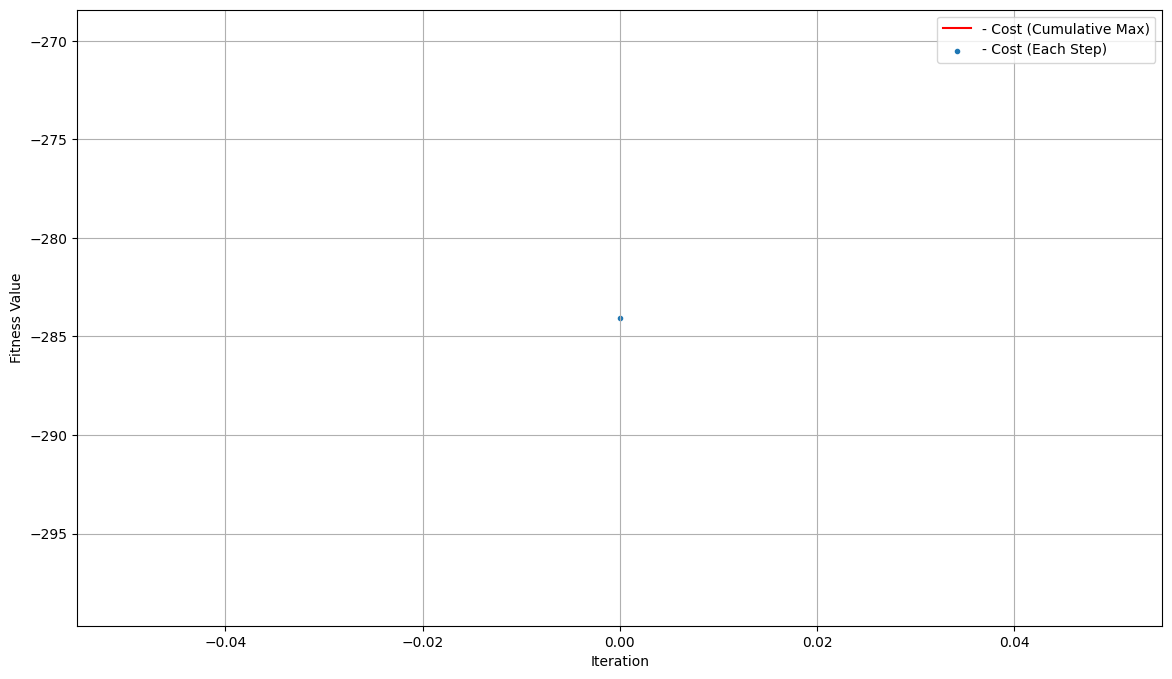

(True, 284.0492127923681), 0


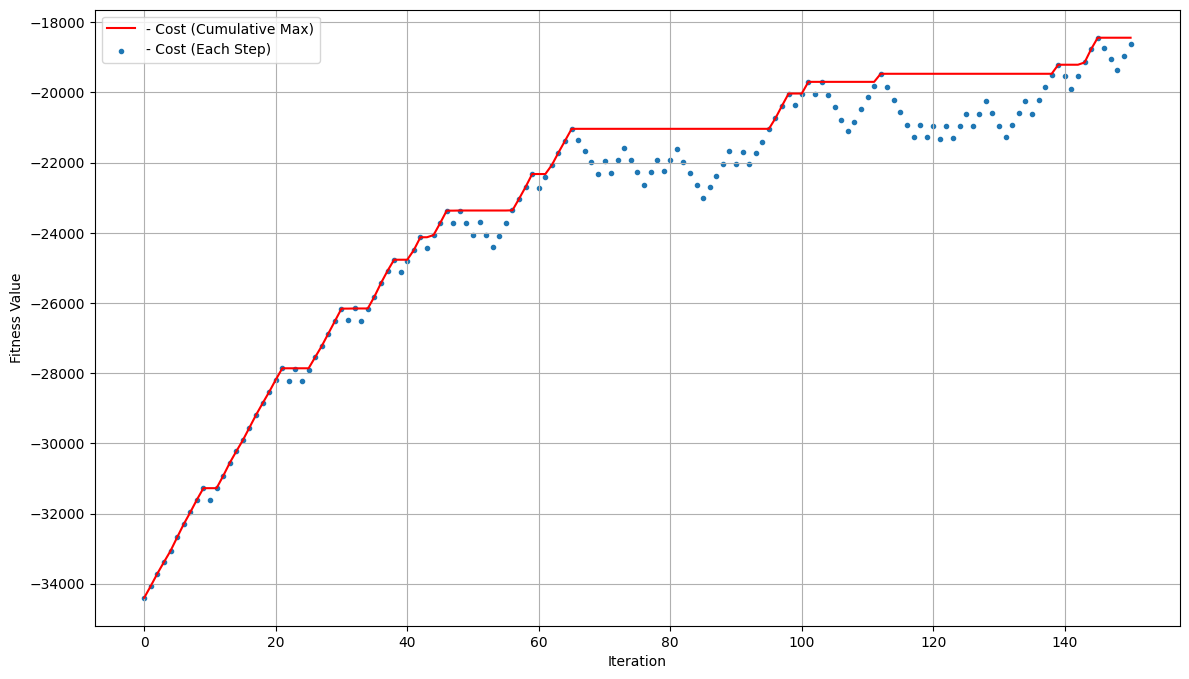

(True, 18619.085249013995), 150


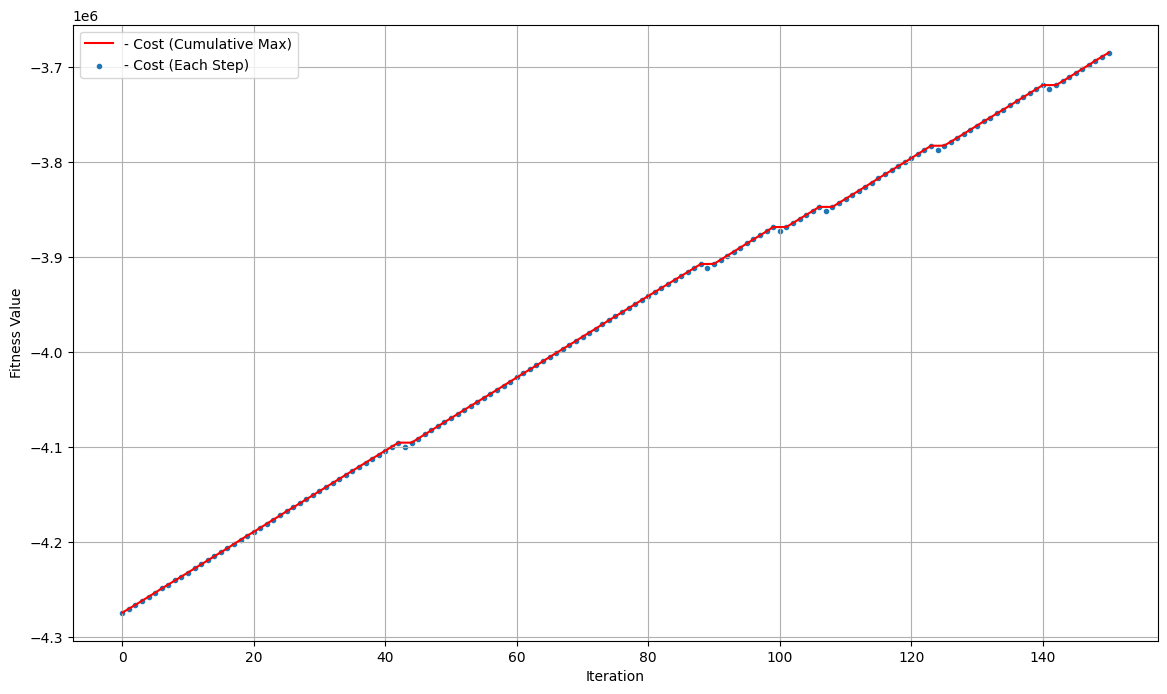

(True, 3684647.9855339155), 150


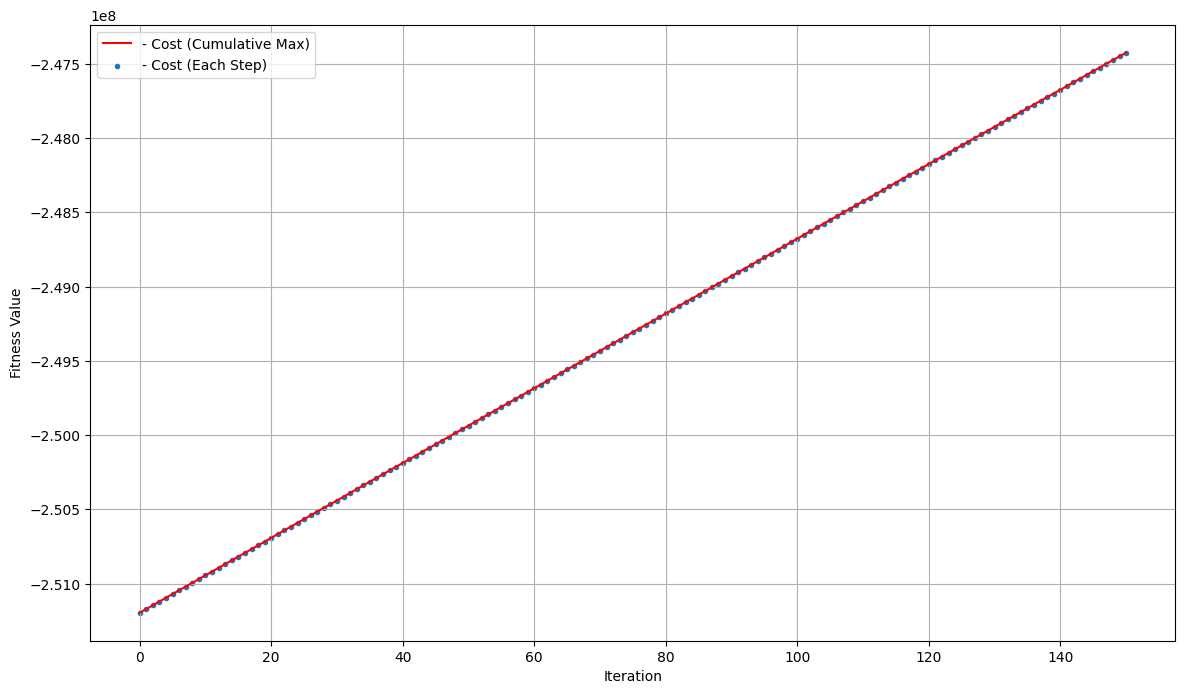

(True, 247426117.35413113), 150


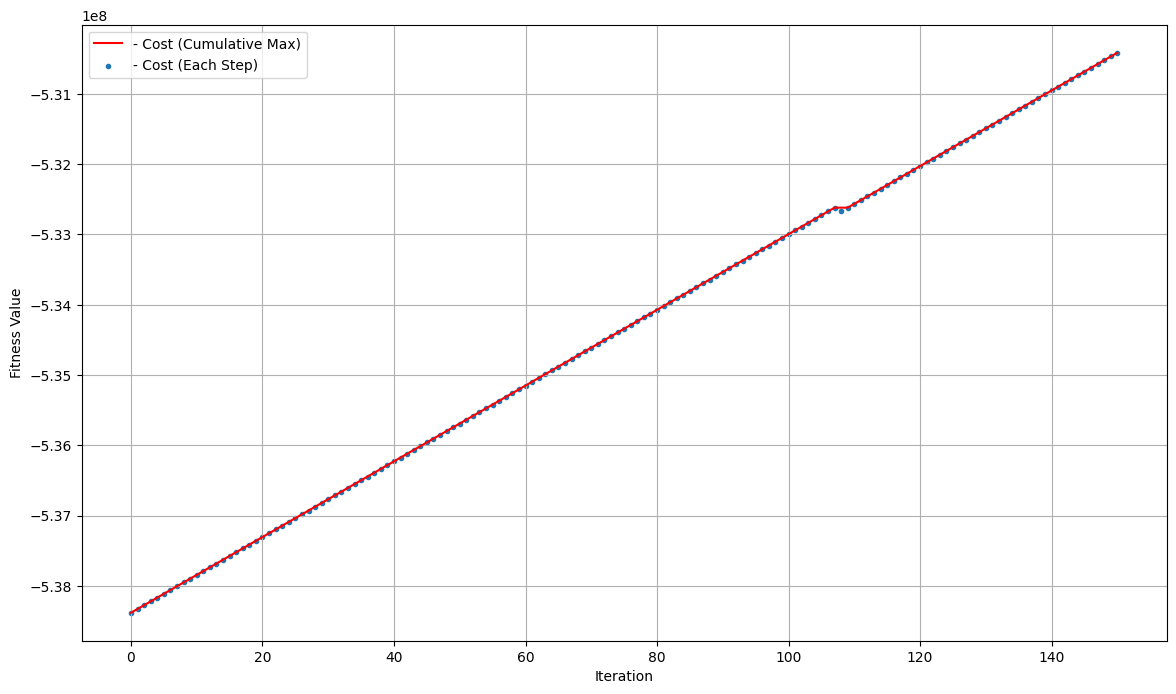

(True, 530414065.913851), 150


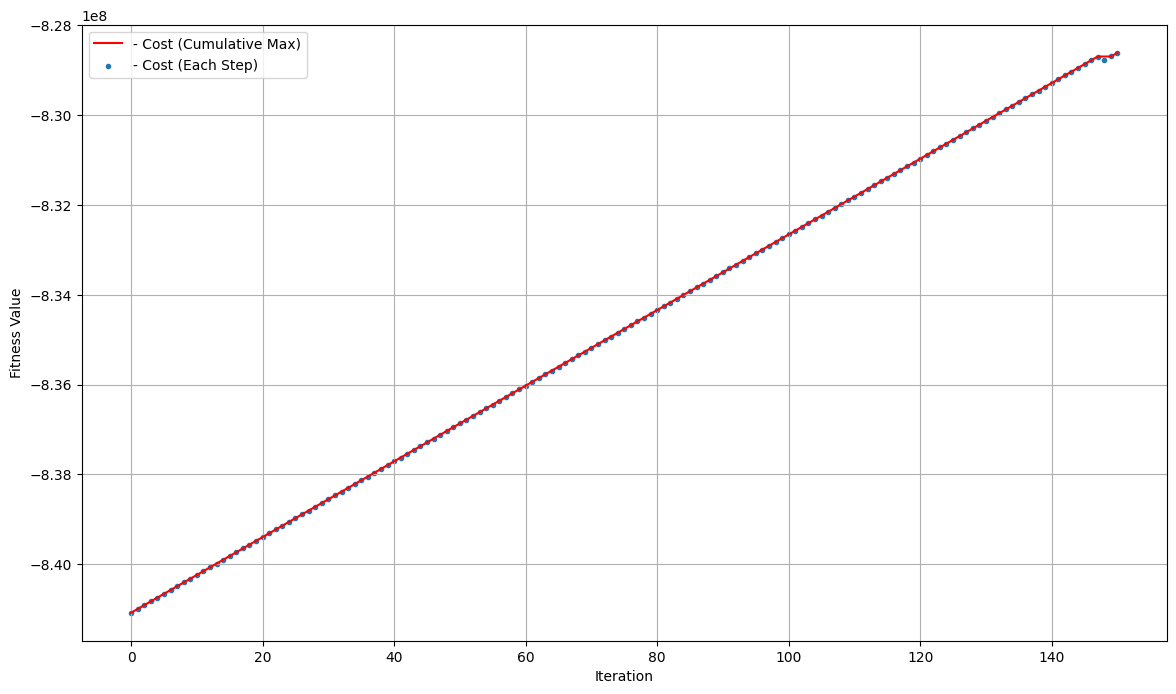

(True, 828621782.3473662), 150


In [51]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution, step = hill_climb(tweak1, starting_point, fitness, plotter, 1)
    print(f"({valid(solution)}, {cost(solution)}), {step}")


# Hill Climbing Multiple-RM

In [39]:
def tweak2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index= rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution

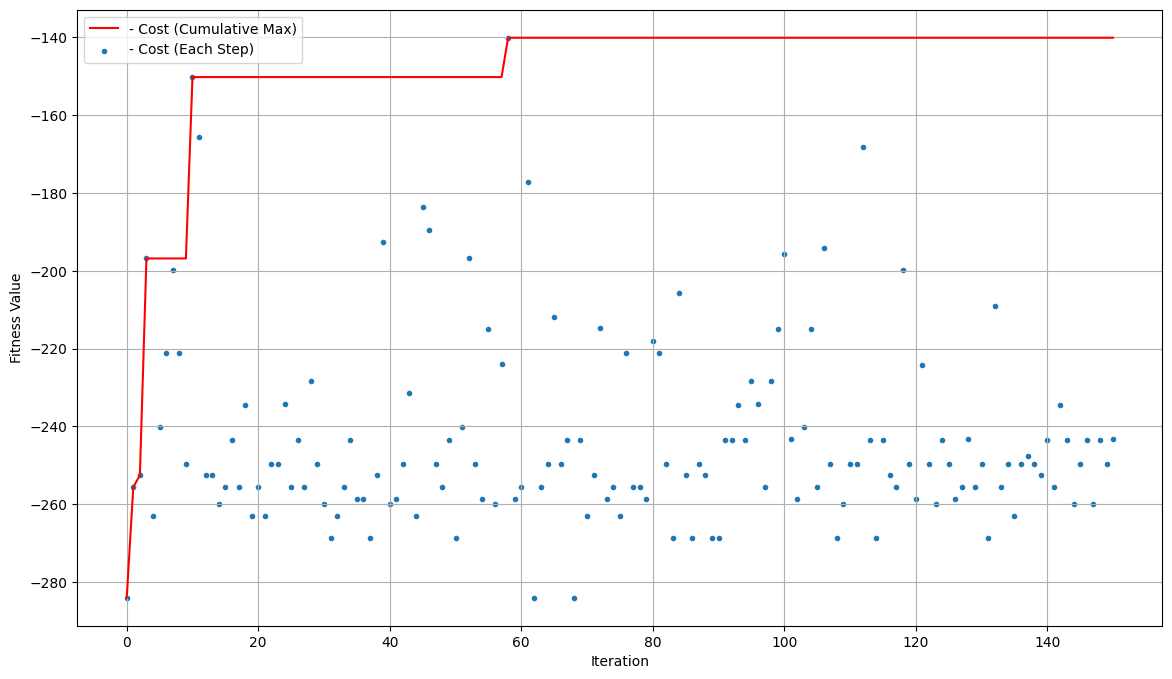

(True, 284.0492127923681), 0


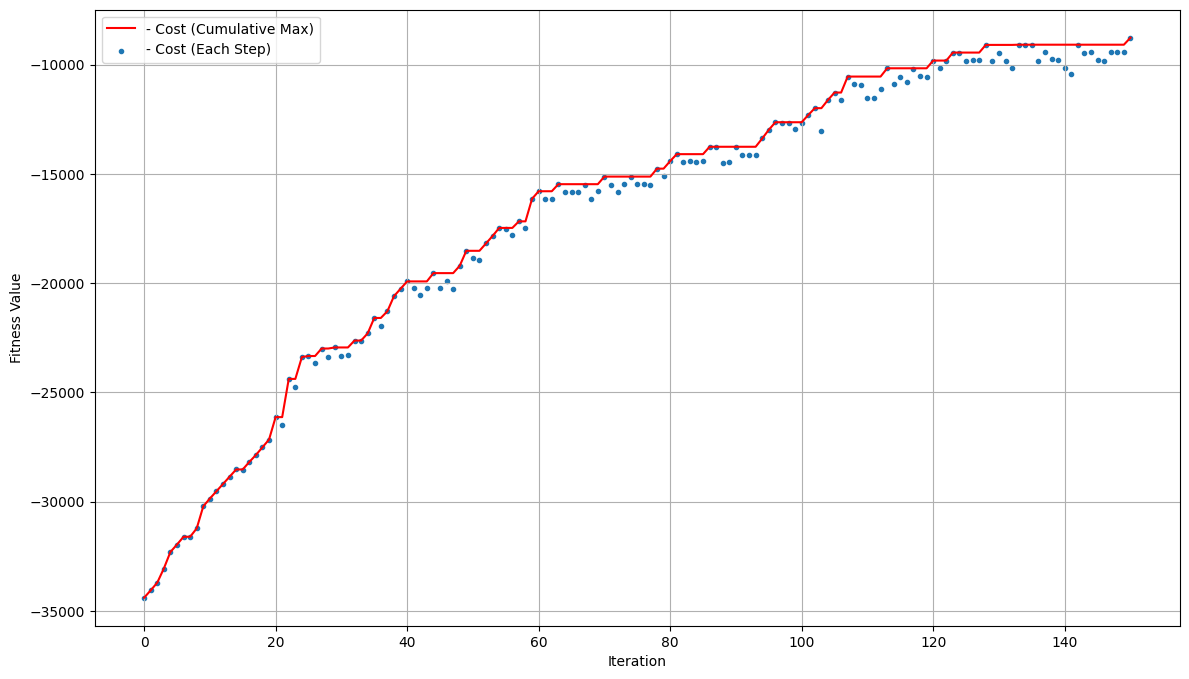

(True, 8773.914578801838), 150


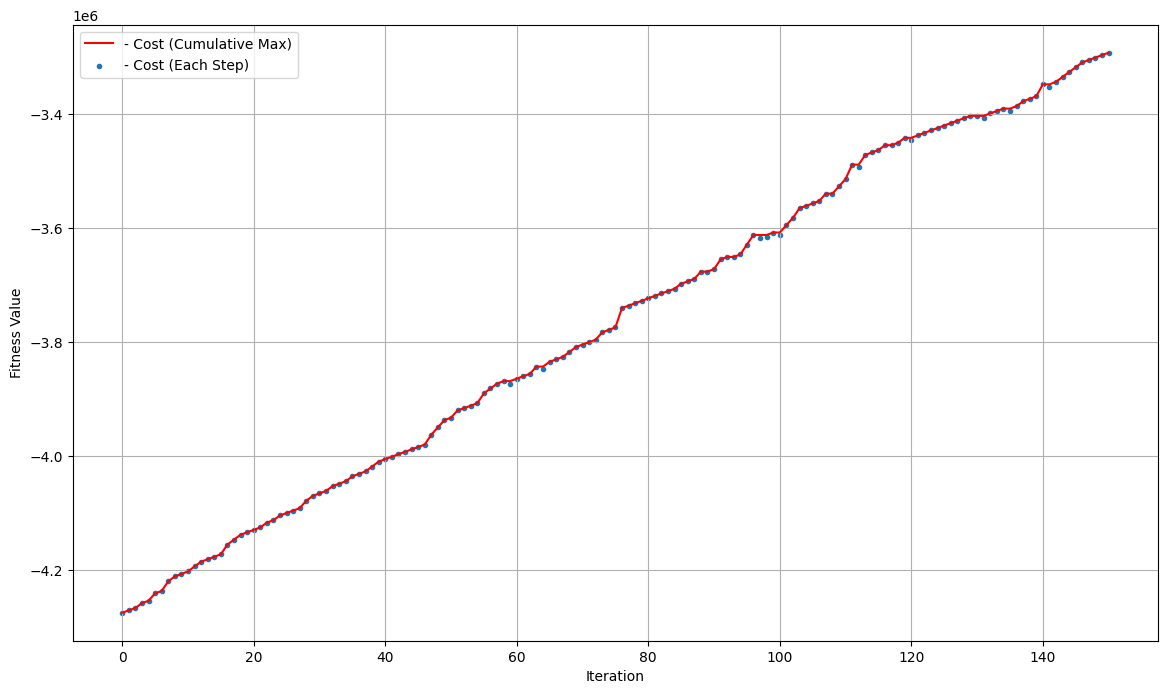

(True, 3292258.709935088), 150


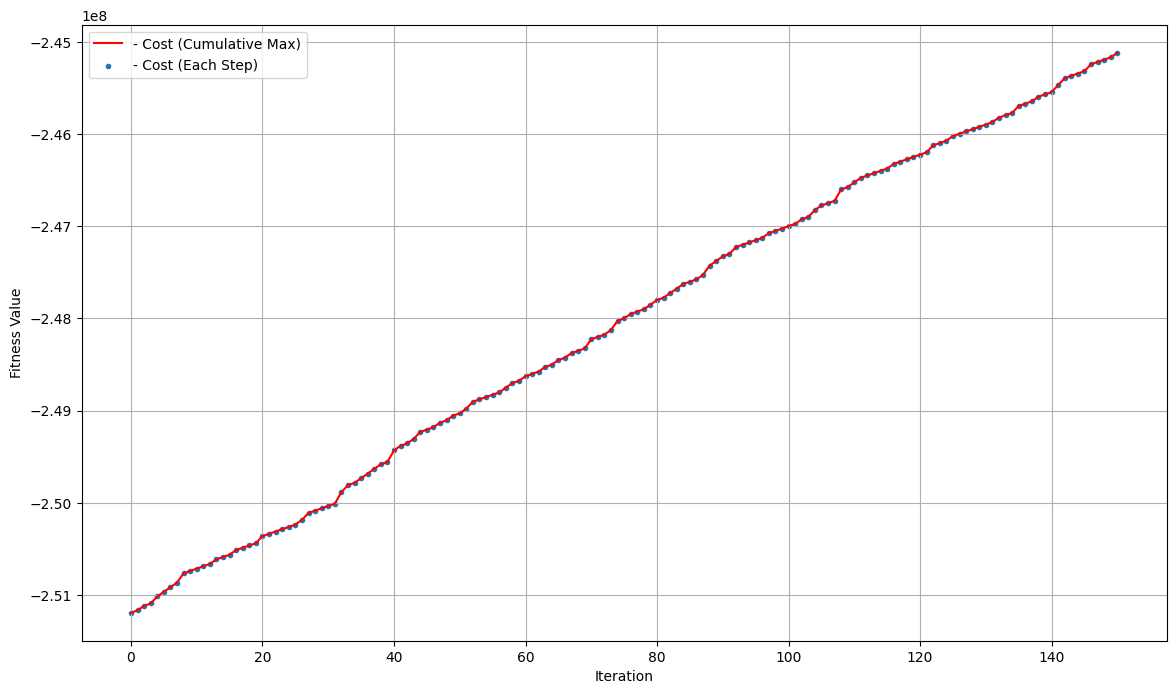

(True, 245114862.75205576), 150


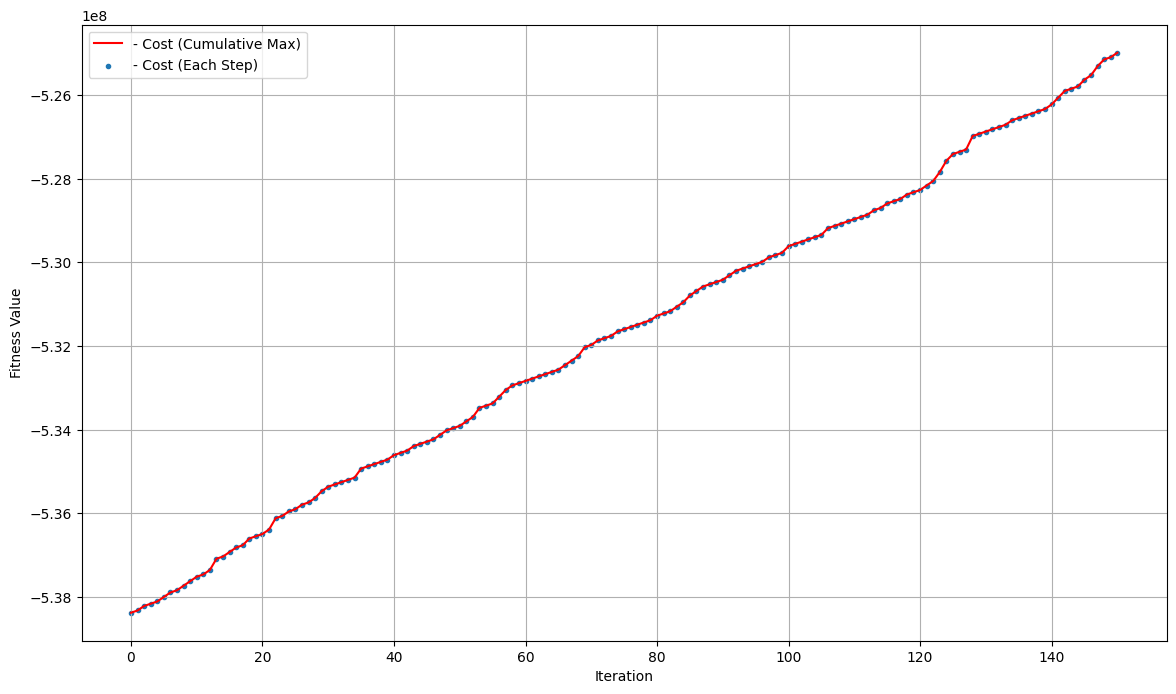

(True, 524978851.3507892), 150


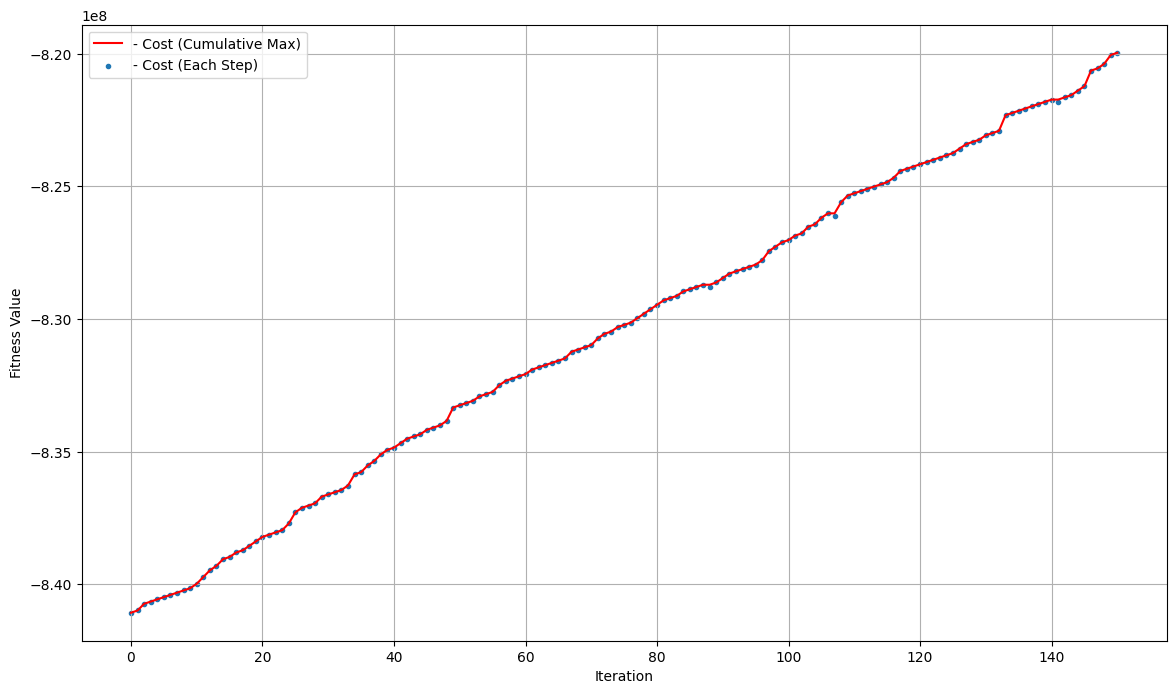

(True, 819956817.8319772), 150


In [40]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution, max_index = hill_climb(tweak2, starting_point, fitness, plotter, 1)
    print(f"({valid(solution)}, {cost(solution)}), {max_index}")


# Hill Climbing  Multiple-RMHC (2° Version)

In [41]:
def tweak2_improved(solution):
    new_solution = solution.copy()

    activate_set = rng.random() < 0.5
    
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    
    
    while np.random.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    
    return new_solution


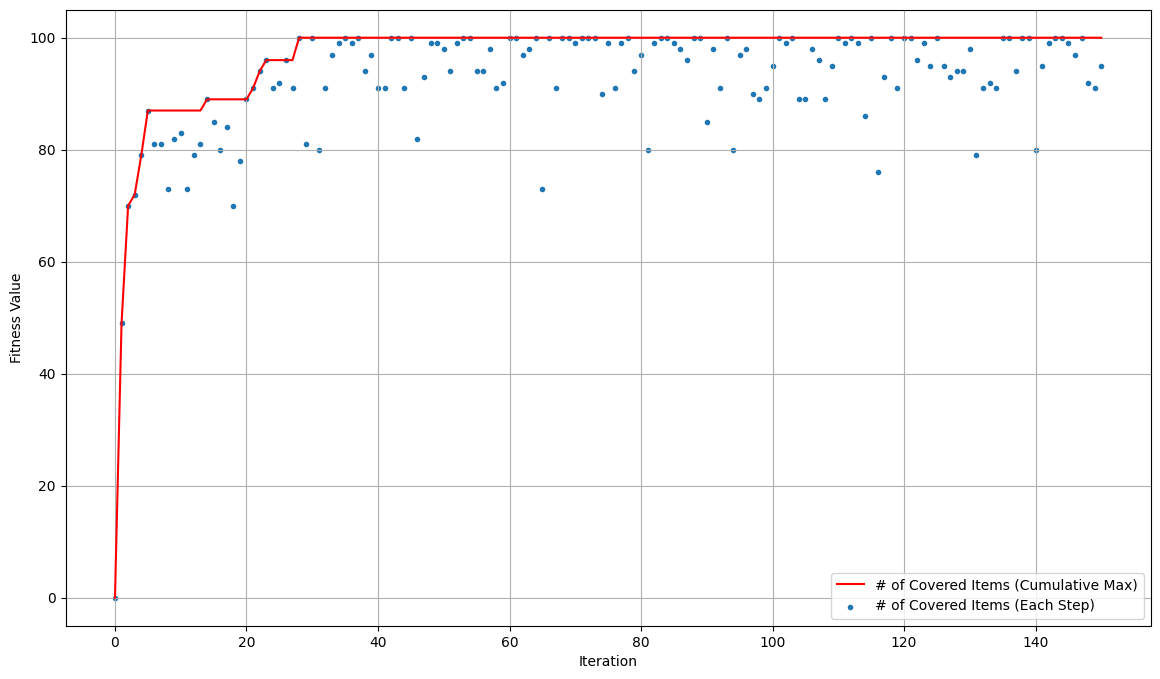

(True, 284.0492127923681), 28


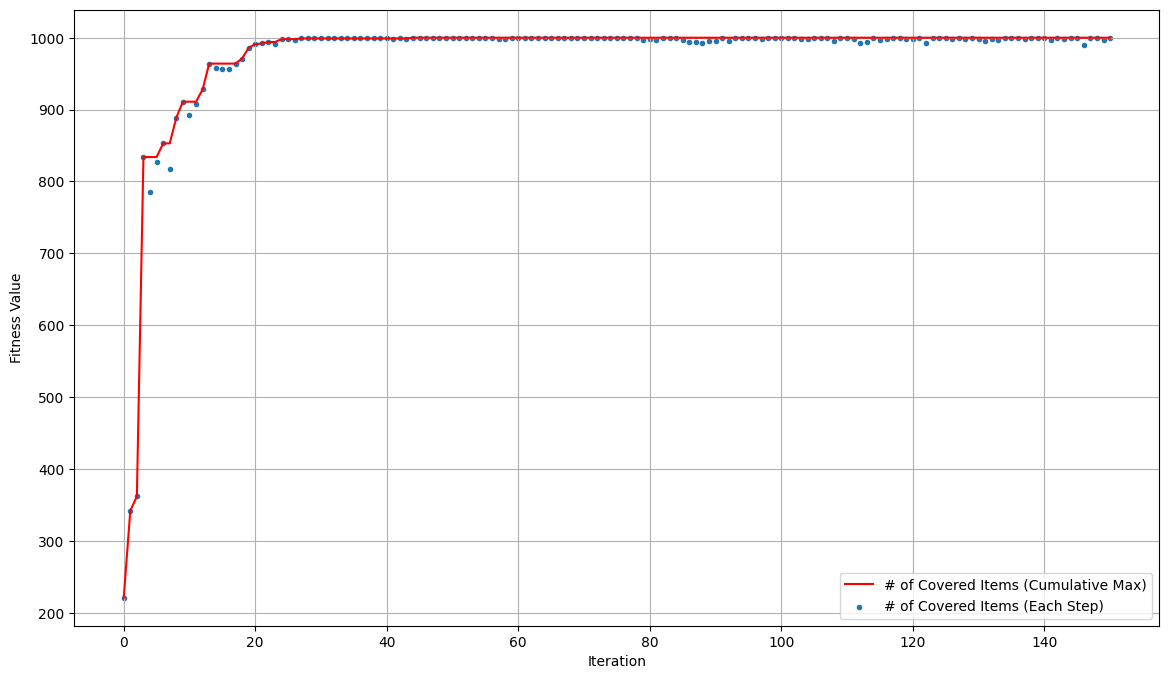

(True, 7305.810318969143), 100


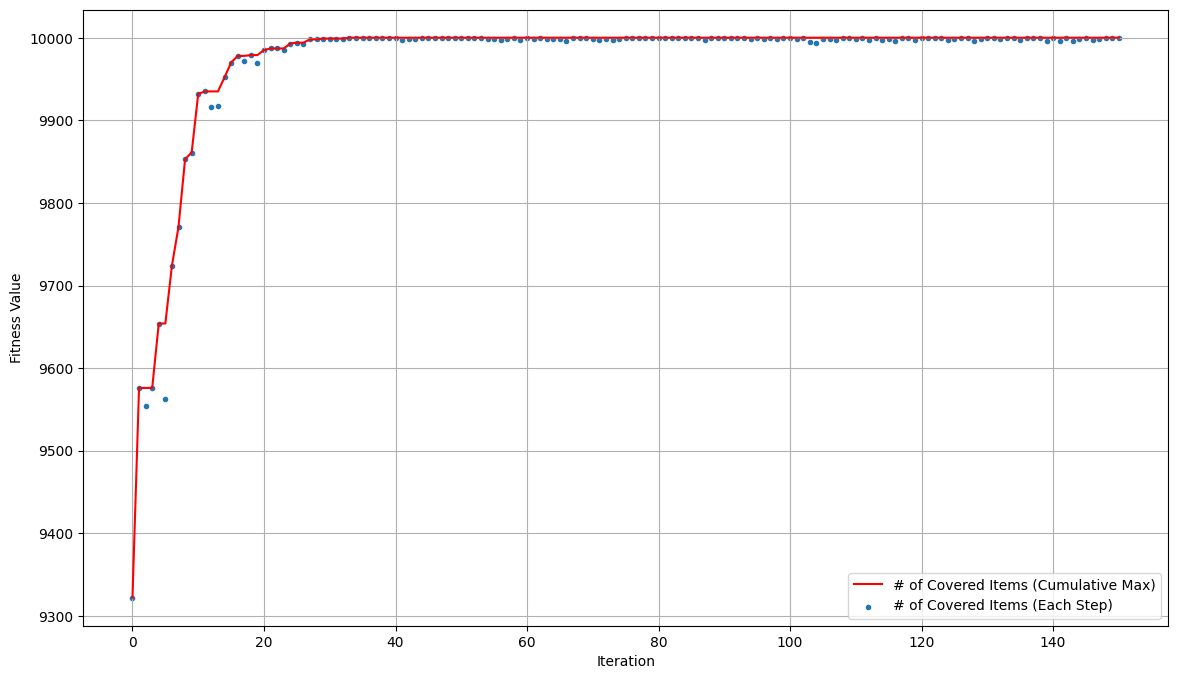

(True, 132075.17206707722), 130


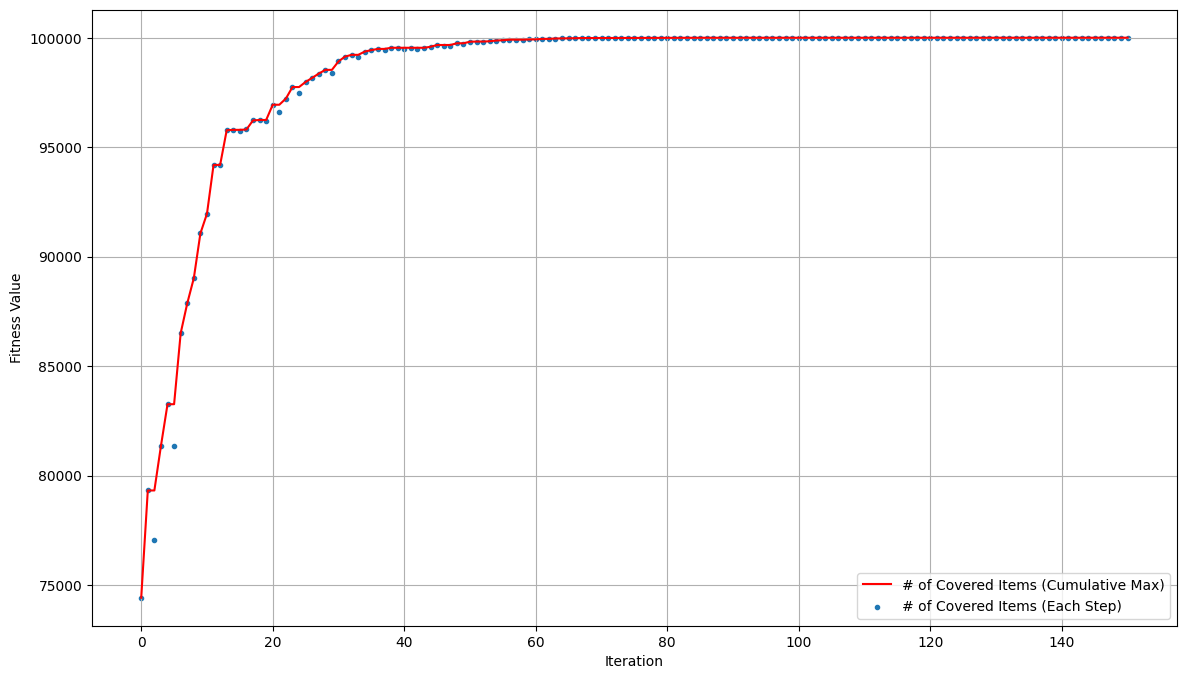

(True, 2282164.165071411), 146


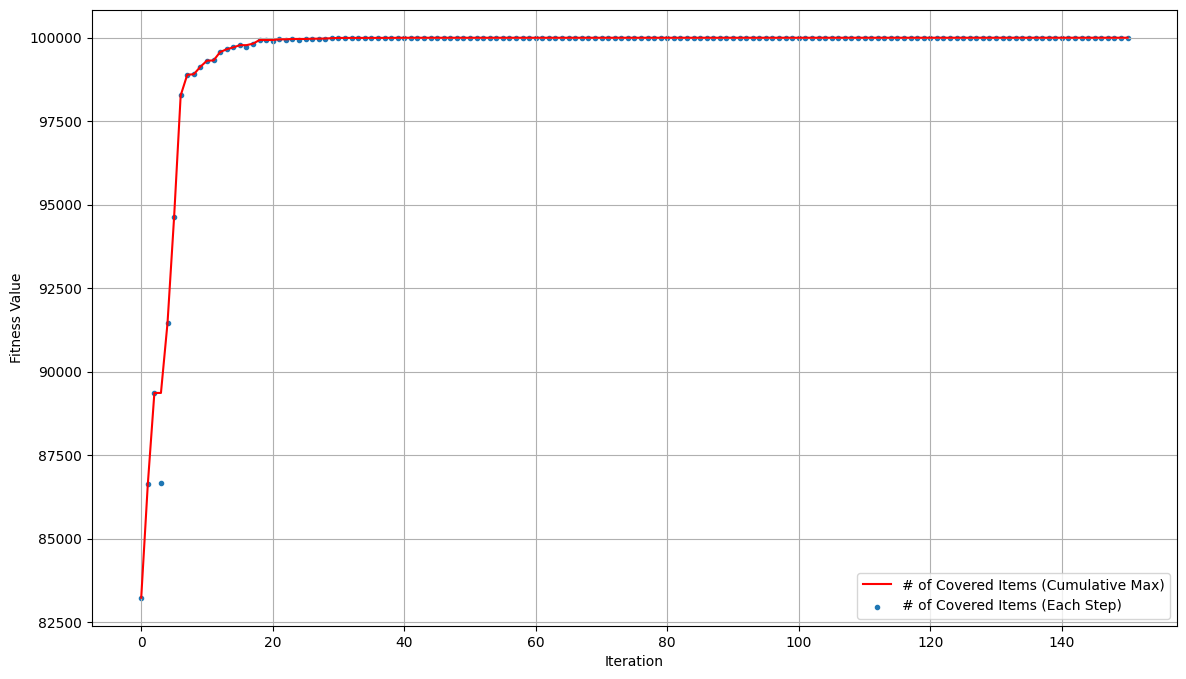

(True, 2260181.3186709373), 139


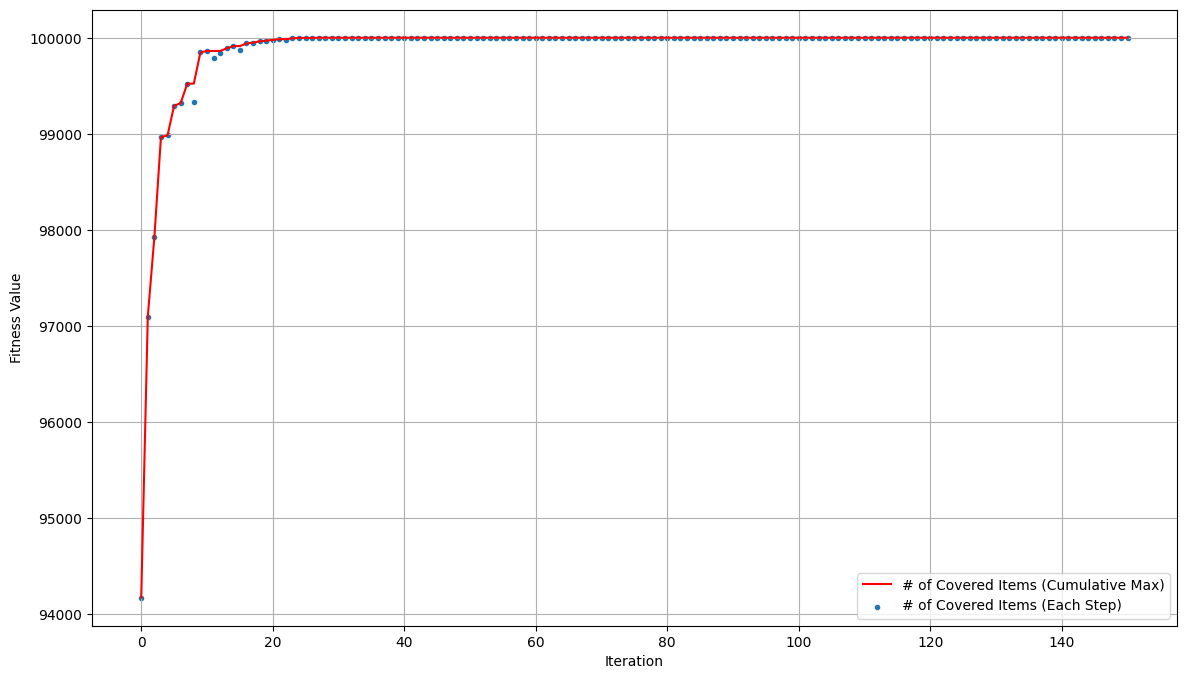

(True, 2183789.6784969247), 92


In [42]:
for universe_size, num_sets, density, p in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY, var_p):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution, max_index = hill_climb(tweak2_improved, starting_point, fitness_improved, plotter2, p)
    print(f"({valid(solution)}, {cost(solution)}), {max_index}")


# Steepest step and restart

In [43]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = MAX_STEPS // STEEPEST_STEP_CANDIDATES
def steepest_step(p):
    history = list()
    index = 0
    max_index = 0
    for i in tqdm(range(NUM_RESTARTS), position=0):
        solution = starting_point(p)
        history.append(fitness_improved(solution))
        for _ in tqdm (range(TRUE_MAX_STEPS//NUM_RESTARTS), position=1, desc=f'step {i+1}'):
            candidates = [tweak2_improved(solution) for _ in range(STEEPEST_STEP_CANDIDATES)]
            candidates_fitness = list()
            index += 1
            for candidate in candidates:
                candidates_fitness.append(fitness_improved(candidate))
                history.append(fitness_improved(candidate))
            idx = candidates_fitness.index(max(candidates_fitness))   
            new_solution = candidates[idx]
            new_fitness = candidates_fitness[idx]
            if new_fitness > fitness_improved(solution):
                solution = new_solution
                max_index = index

    plotter2(history)
    return solution, max_index


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

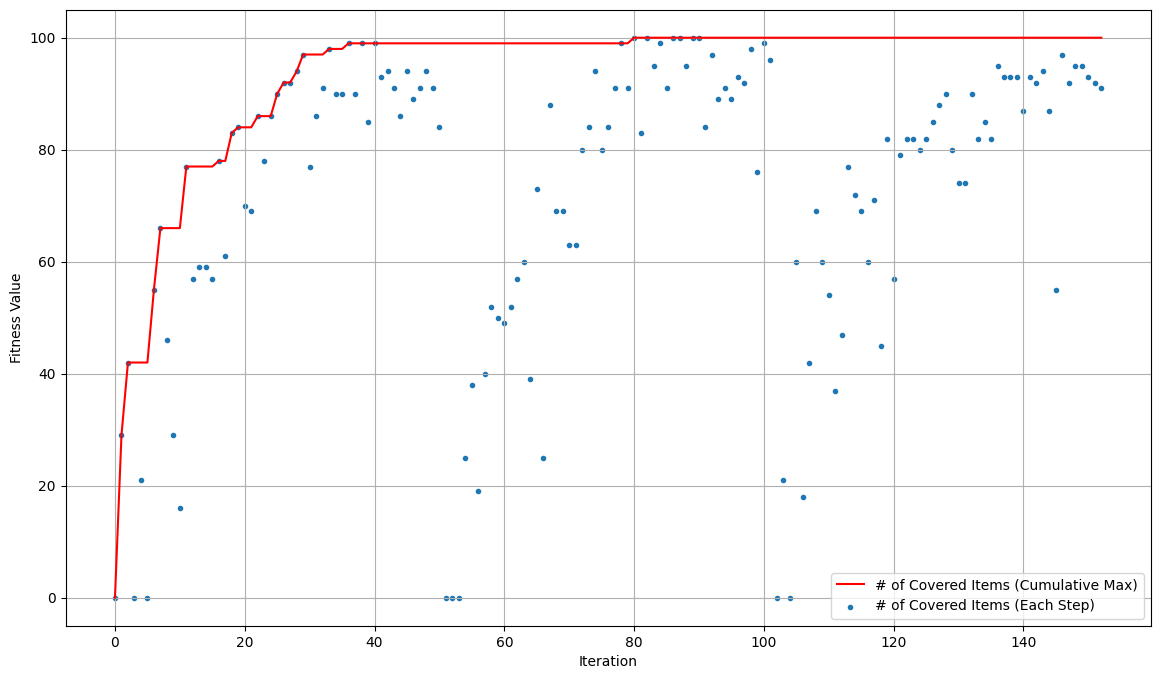

(False, 234.463561979431), 29


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

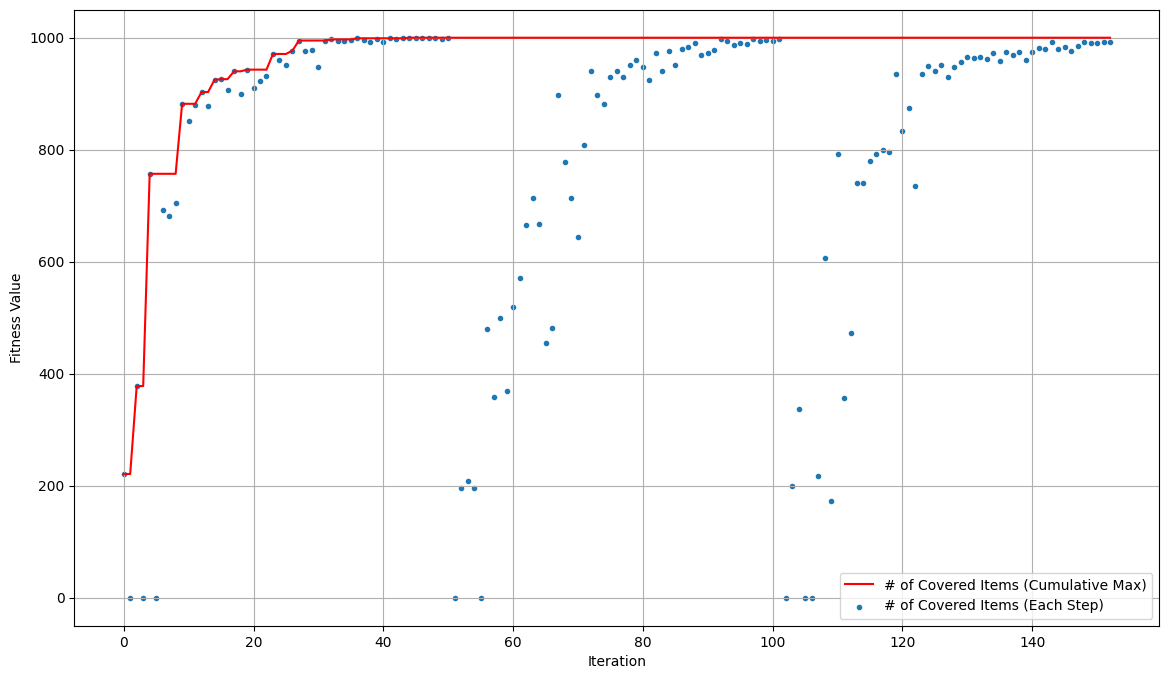

(False, 6890.432853579595), 30


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

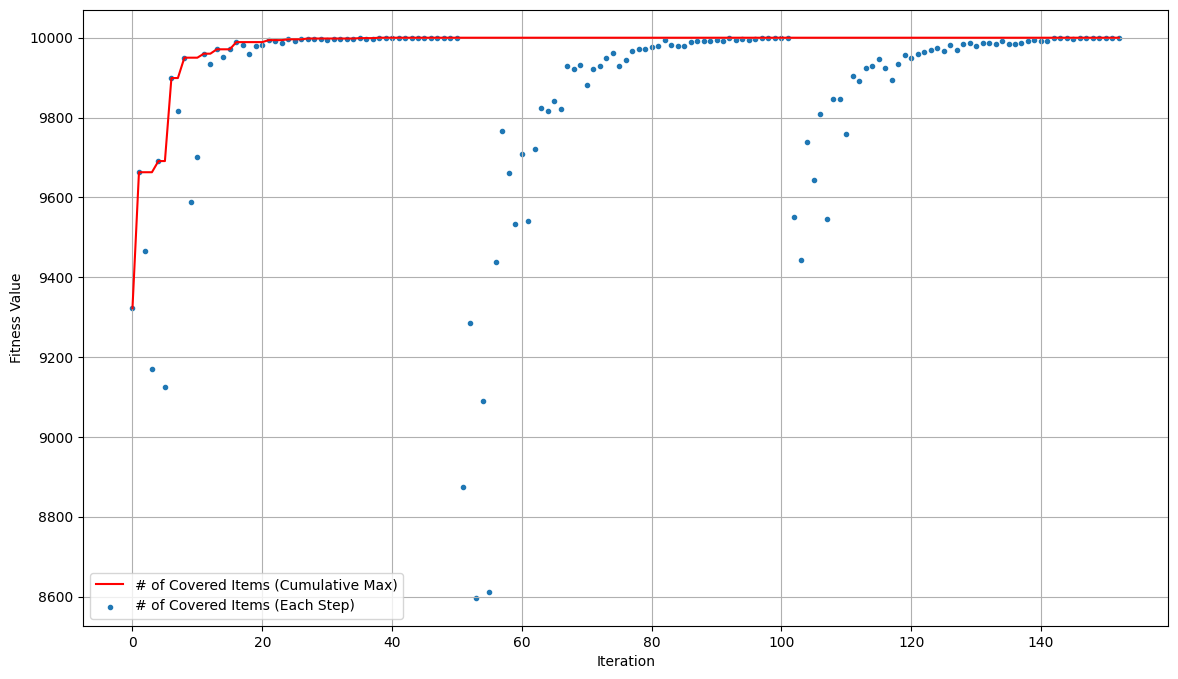

(True, 161880.1947167721), 30


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

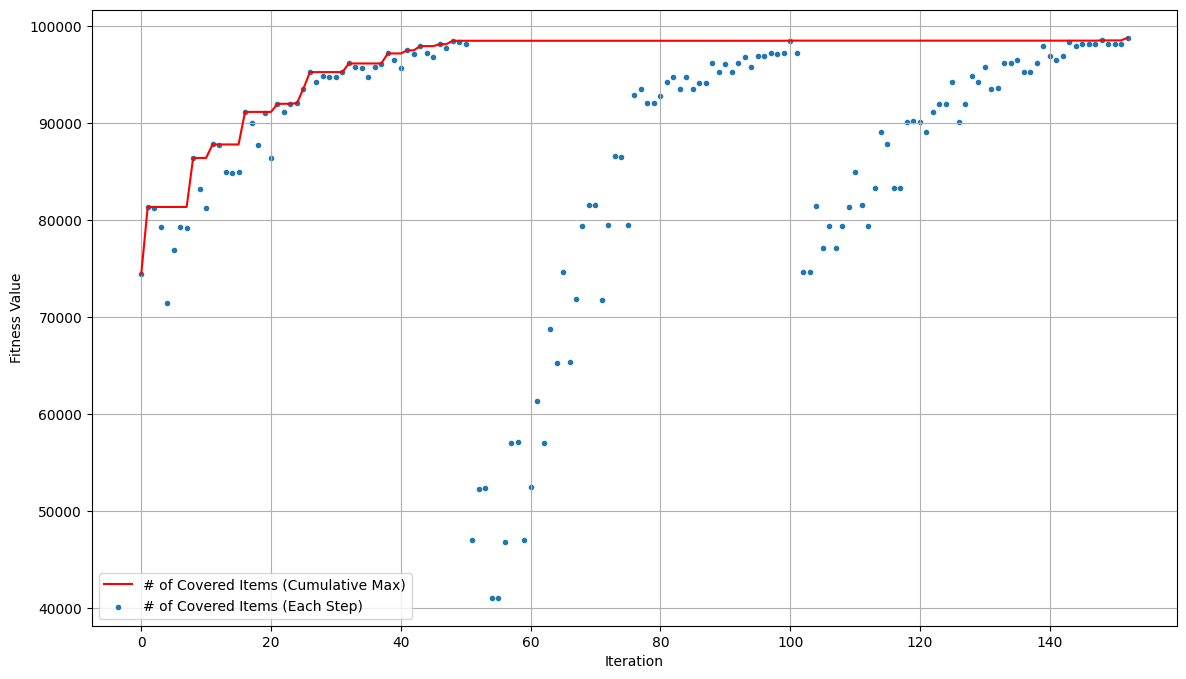

(False, 1056445.2927075657), 30


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

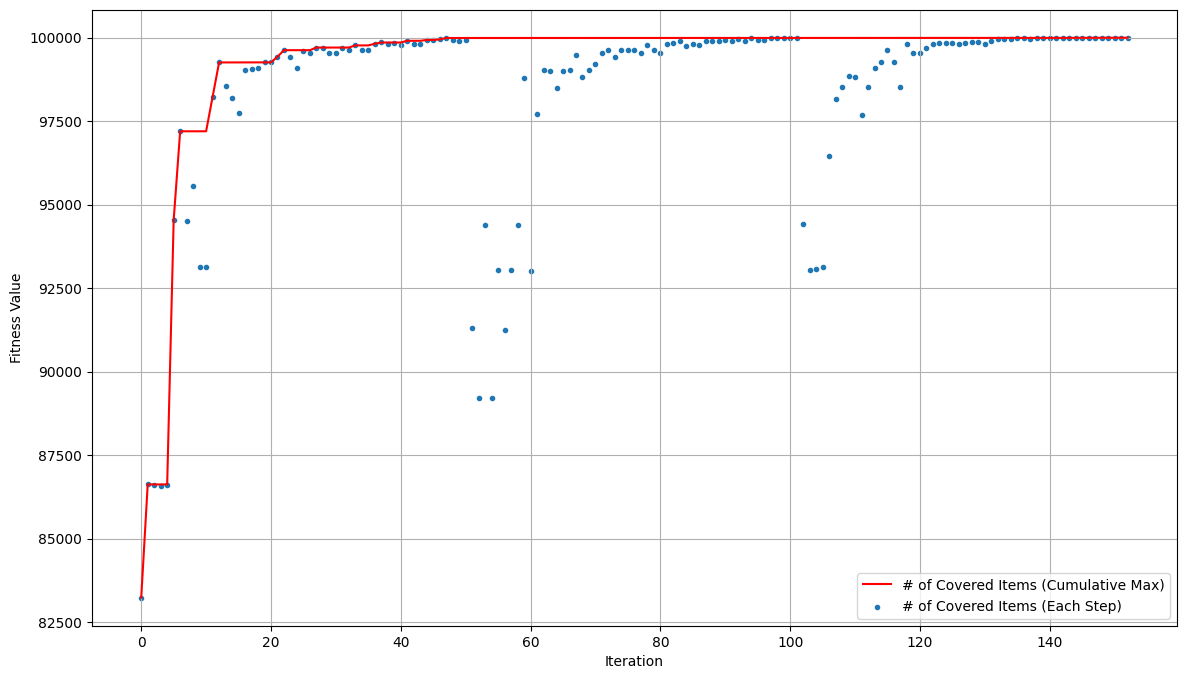

(False, 2318950.5477640643), 30


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/10 [00:00<?, ?it/s]

step 2:   0%|          | 0/10 [00:00<?, ?it/s]

step 3:   0%|          | 0/10 [00:00<?, ?it/s]

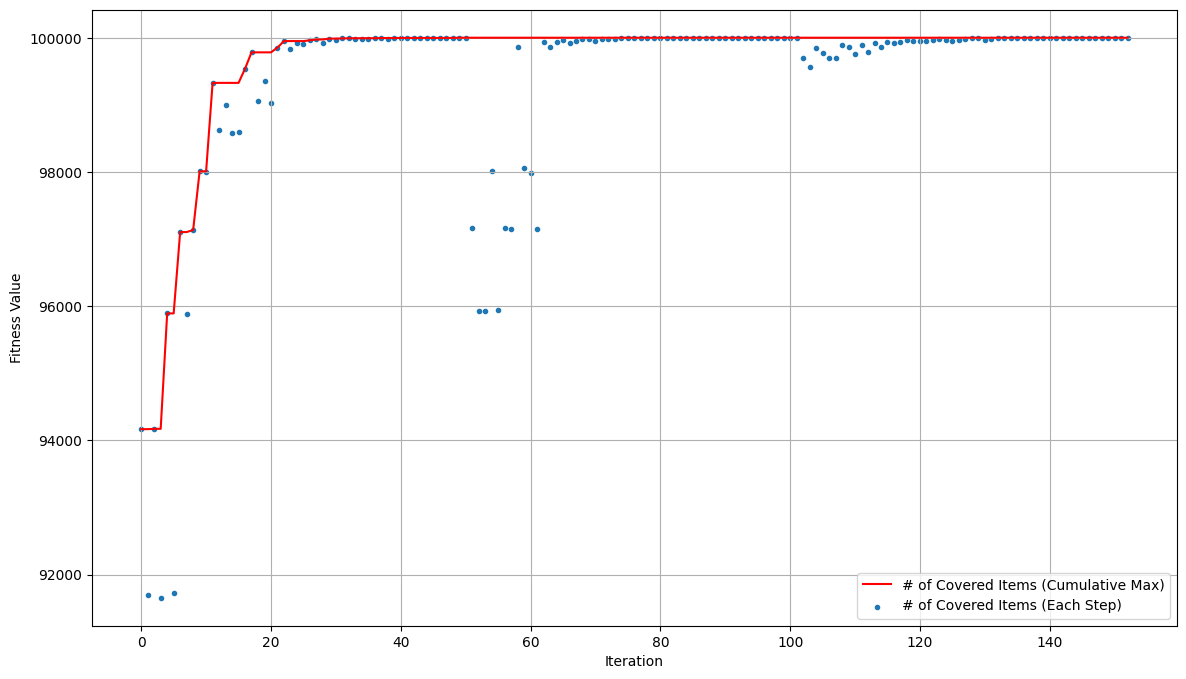

(True, 2518945.4385763425), 30


In [44]:
for universe_size, num_sets, density, p in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY, var_p):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution, max_index = steepest_step(p)
    print(f"({valid(solution)}, {cost(solution)}), {max_index}")

# Simulated Annealing

In [1]:
INITIAL_TEMPERATURE = 1000 
COOLING_RATE = 0.995 
PENALTY_WEIGHT = 1e6
def simulated_annealing(tweak, sp, f, plot, p):
   
    S = sp(p)  
    Best = S.copy() 
    current_fitness = f(S)
    current_items, current_cost = current_fitness

    temperature = INITIAL_TEMPERATURE
    current_p = PENALTY_WEIGHT * (not valid(S))
    current_fitness = (current_fitness[0]-current_p, current_fitness[1]-current_p)
    history = [(current_items, current_cost)]
    index = 0
    max_index = 0
    while temperature > 1e-10:  
        R = tweak(S.copy()) 
        new_fitness = f(R) 
        new_items, new_cost = new_fitness  
        new_p = PENALTY_WEIGHT * (not valid(R))
        new_fitness = (new_items-new_p, new_cost-new_p)
        euclidian_distance = np.linalg.norm(np.array(new_fitness) - np.array(current_fitness))
        index += 1
        if (euclidian_distance > 0 ) or rng.random() < math.exp((euclidian_distance) / temperature):
            S = R
            current_items, current_cost = new_items, new_cost 
            history.append((current_items, current_cost))  
            
            
            if new_fitness > f(Best) and valid(R): 
                Best = S.copy() 
                max_index = index

        
        temperature *= COOLING_RATE
   
    plot(history)
    return Best, max_index


In [2]:
for universe_size, num_sets, density, p in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY, var_p):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution, max_index = simulated_annealing(tweak2_improved, starting_point, fitness_improved, plotter2, p)
    print(f"({valid(solution)}, {cost(solution)}), {max_index}")

NameError: name 'var_UNIVERSE_SIZE' is not defined

# Tabù Search

In [23]:
def tabu_search(tweak, sp, f, plot, max_tabu_size, n, p):   
    S = sp(p) 
    Best = S.copy()
    tabu_list = [tuple(S.copy())]  
    current_p = PENALTY_WEIGHT * (not valid(S))
    current_fitness = (f(S)[0] - current_p, f(S)[1] - current_p)
    history = [current_fitness] 
    index = 0
    max_index = 0
    for _ in range(1000):
        if len(tabu_list) > max_tabu_size:
            tabu_list.pop(0)
        R = tweak(S.copy())
        
        new_fitness = f(R)
        index
        for _ in range(n-1):
            W = tweak(S.copy())
            new_p_W = PENALTY_WEIGHT * (not valid(W))
            new_fitness_W = (f(W)[0] - new_p_W, f(W)[1] - new_p_W)
            index += 1
            if tuple(W) not in tabu_list and (new_fitness_W > new_fitness or tuple(R) in tabu_list):
                R = W

        if tuple(R) not in tabu_list:
            S = R.copy()
            tabu_list.append(tuple(S.copy()))
            current_fitness = f(S)
        
        if current_fitness > f(Best):
            Best = S.copy()
            max_index = index

        history.append(current_fitness)

    plot(history)
    return Best, max_index


In [6]:
for universe_size, num_sets, density, p in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY, var_p):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = tabu_search(tweak2_improved, starting_point, fitness_improved, plotter2,20,10, p)
    print(f"({valid(solution)}, {cost(solution)}, {max_index})")

NameError: name 'var_UNIVERSE_SIZE' is not defined